### A code which creates the Wigner interactive function in 2D and 3D with different squeezing parameters.

In [30]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from numba import njit
%load_ext line_profiler



First testing out the interactive plots

In [22]:
def model(x,A):
    return np.sin(x)*A

def interactive_plot(A):
    x = np.linspace(0,10,100)
    y = model(x,A)
    plt.plot(x,y)
    plt.grid(True)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'{A}sin(x)')
    return

interact(interactive_plot, A=widgets.FloatSlider(value=1, min=-10, max=10, step=0.1))


interactive(children=(FloatSlider(value=1.0, description='A', max=10.0, min=-10.0), Output()), _dom_classes=('…

<function __main__.interactive_plot(A)>

Defining the Wigner function

In [23]:
# Create functions for calculating the Wigner function of a general Gaussian state.

sigma = np.array([[1, 0], [0, 1]])*0.5
det_sigma = np.linalg.det(sigma)
inv_sigma = np.linalg.inv(sigma)

def inv(sigma, delta):
    return np.exp( -0.5 * (delta).T @ np.linalg.inv(sigma) @ (delta) )
"""
@njit 
def WignerFunction(x,p,x_displacement,y_displacement,sigma,theta,r, n=1): 

    S_theta = np.array ([[np.cos(theta), np.sin(theta)],
                         [np.sin(theta), -np.cos(theta)]])
    sigma = 0.5 * np.cosh(2*r)*np.eye(2) - 0.5 * np.sinh(2*r)*S_theta

    r_vec = np.array([x, p])
    
    x_mean = np.mean(x) 
    p_mean = np.mean(p) 

    r_vec_mean = np.array([x_displacement,y_displacement])
    
    delta = r_vec - r_vec_mean

    Wigner = ( 1 / ( (2*np.pi)**n * det_sigma ) ) * np.exp( -0.5 * (delta).T @ inv_sigma @ (delta) )
    return Wigner"""

'\n@njit \ndef WignerFunction(x,p,x_displacement,y_displacement,sigma,theta,r, n=1): \n\n    S_theta = np.array ([[np.cos(theta), np.sin(theta)],\n                         [np.sin(theta), -np.cos(theta)]])\n    sigma = 0.5 * np.cosh(2*r)*np.eye(2) - 0.5 * np.sinh(2*r)*S_theta\n\n    r_vec = np.array([x, p])\n\n    x_mean = np.mean(x) \n    p_mean = np.mean(p) \n\n    r_vec_mean = np.array([x_displacement,y_displacement])\n\n    delta = r_vec - r_vec_mean\n\n    Wigner = ( 1 / ( (2*np.pi)**n * det_sigma ) ) * np.exp( -0.5 * (delta).T @ inv_sigma @ (delta) )\n    return Wigner'

In [ ]:
x = np.linspace(-5,5,200)
p = np.linspace(-5,5,200)

X,P = np.meshgrid(x,p)
W = np.zeros_like(X)


def compute_sigma(theta, r):
    S_theta = np.array([[np.cos(theta), np.sin(theta)],
                        [np.sin(theta), -np.cos(theta)]])
    sigma = 0.5 * np.cosh(2*r)*np.eye(2) - 0.5 * np.sinh(2*r)*S_theta
    return sigma

inv_sigma = np.linalg.inv(sigma)
det_sigma_sqrt = np.sqrt(np.linalg.det(sigma))

@njit
def wigner_function_numba(X, P, x_disp, y_disp, inv_sigma, det_sigma_sqrt, r, theta):
    dx = X - x_disp
    dp = P - y_disp
    
    # Quadratic form delta.T @ inv_sigma @ delta (expanded for 2D)
    #exponent = np.exp( -0.5 * (np.array([dx, dp])).T @ inv_sigma @ (np.array([dx, dp])) ) Its just explicit written out instead of the line above
    exponent = -0.5 * (inv_sigma[0,0]*dx*dx + 
                       (inv_sigma[0,1] + inv_sigma[1,0])*dx*dp + 
                       inv_sigma[1,1]*dp*dp)
    
    normalization = 1.0 / ((2*np.pi)**1 * det_sigma_sqrt)
    
    return normalization * np.exp(exponent)


Creating a function which changes sigma depending on the squeezing factor

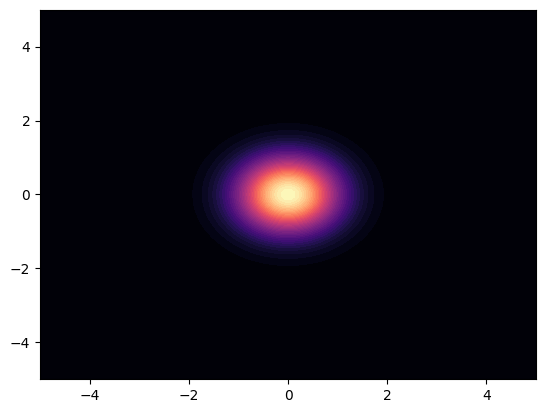

In [25]:
theta_1 = 0.0
r_1 = 0

x_disp = 0.0
y_disp = 0.0

W1 = wigner_function_numba(X, P, x_disp, y_disp, inv_sigma, det_sigma_sqrt, r_1, theta_1)

plt.contourf(X, P, W1, levels=50, cmap='magma')

In [26]:
def interactive_Wigner_Plot(r, x_disp, y_disp, theta):

    sigma = compute_sigma(theta, r)
    inv_sigma = np.linalg.inv(sigma)
    det_sigma_sqrt = np.sqrt(np.linalg.det(sigma))

    W = wigner_function_numba(X, P, x_disp, y_disp, inv_sigma, det_sigma_sqrt, r, theta)

    plt.figure(figsize=(8,6))
    plt.contourf(X, P, W, levels=50, cmap='magma')
    plt.colorbar(label='Wigner function')
    plt.xlabel('x')
    plt.ylabel('p')
    plt.title('2D Wigner function plot')
    plt.show()
    return

In [ ]:
interact(interactive_Wigner_Plot, 
         r=widgets.FloatSlider(value=0, min=-3, max=3, step=0.1),
         x_disp=widgets.FloatSlider(value=0.0, min=-4.0, max=4.0, step=0.1, description='x'),
         y_disp=widgets.FloatSlider(value=0.0, min=-4.0, max=4.0, step=0.1, description='p'),
         theta=widgets.FloatSlider(value=0.0, min=-2*np.pi, max=2*np.pi, step=0.1, description='theta'))

interactive(children=(FloatSlider(value=0.0, description='r', max=3.0, min=-3.0), FloatSlider(value=0.0, descr…

<function __main__.interactive_Wigner_Plot(r, x_disp, y_disp, theta)>

In [ ]:
def interactive_Wigner_Plot_3D(r, x_disp, y_disp, theta):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    sigma = compute_sigma(theta, r)
    inv_sigma = np.linalg.inv(sigma)
    det_sigma_sqrt = np.sqrt(np.linalg.det(sigma))

    W = wigner_function_numba(X, P, x_disp, y_disp, inv_sigma, det_sigma_sqrt, r, theta)

    ax.plot_surface(X, P, W, cmap='magma', edgecolor='none')

    ax.set_xlabel('x')
    ax.set_ylabel('p')
    ax.set_zlabel('W(x, p)')
    ax.set_title('3D Wigner Function')

    plt.tight_layout()
    plt.show()

    return

interact(interactive_Wigner_Plot_3D, 
         r=widgets.FloatSlider(value=0, min=-3, max=3, step=0.1),
         x_disp=widgets.FloatSlider(value=0.0, min=-4.0, max=4.0, step=0.1, description='x₀'),
         y_disp=widgets.FloatSlider(value=0.0, min=-4.0, max=4.0, step=0.1, description='p₀'),
         theta=widgets.FloatSlider(value=0.0, min=-2*np.pi, max=2*np.pi, step=0.1, description='theta'))

interactive(children=(FloatSlider(value=0.0, description='r', max=3.0, min=-3.0), FloatSlider(value=0.0, descr…

<function __main__.interactive_Wigner_Plot_3D(r, x_disp, y_disp, theta)>

In [32]:
%lprun -f compute_sigma -f inv wigner_function_numba(X, P, 0, 0, inv_sigma, det_sigma_sqrt, 0, 0)

Timer unit: 1e-09 s

Total time: 0 s
File: /var/folders/l_/0gbbhqcj6wg0zv6lyz_3rhpc0000gn/T/ipykernel_23941/2157671244.py
Function: compute_sigma at line 8

Line #      Hits         Time  Per Hit   % Time  Line Contents
     8                                           def compute_sigma(theta, r):
     9                                               S_theta = np.array([[np.cos(theta), np.sin(theta)],
    10                                                                   [np.sin(theta), -np.cos(theta)]])
    11                                               sigma = 0.5 * np.cosh(2*r)*np.eye(2) - 0.5 * np.sinh(2*r)*S_theta
    12                                               return sigma

Total time: 0 s
File: /var/folders/l_/0gbbhqcj6wg0zv6lyz_3rhpc0000gn/T/ipykernel_23941/3424639327.py
Function: inv at line 7

Line #      Hits         Time  Per Hit   % Time  Line Contents
     7                                           def inv(sigma, delta):
     8                                     

In [35]:
%timeit W = wigner_function_numba(X, P, 0, 0, inv_sigma, det_sigma_sqrt, 0, 0)

631 μs ± 43.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


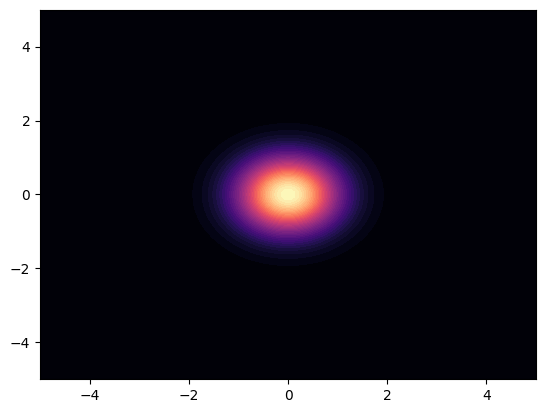

In [34]:
plt.contourf(X, P, W1, levels=50, cmap='magma')